# Classification

## Importer les données Titanic ".csv"

In [1]:
import pandas as pd

In [2]:
# Lecture du fichier ".csv"
path = "~/Documents/PDS/Cours/Data/train.csv"
train = pd.read_csv(path, sep=",")

# Affichage des cinq premières lignes
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
survived = train[train.Survived == 1]
dead = train[train.Survived == 0]

## Distribution relative des survivants/ non surviants en fonction de la classe

Populating the interactive namespace from numpy and matplotlib


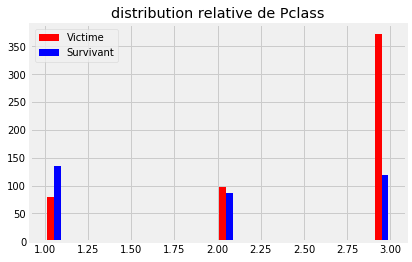

In [4]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline
%pylab inline

def plot_hist(feature, bins=20):
    x1 = np.array(dead[feature].dropna())
    x2 = np.array(survived[feature].dropna())
    plt.hist([x1,x2], label=["Victime", "Survivant"], bins = bins, color=["red","blue"])
    plt.legend(loc="upper left")
    plt.title('distribution relative de %s' %feature)
    plt.show()
    
plot_hist('Pclass')

In [5]:
def parse_model2(X):
    if "Survived" not in X.columns:
        raise ValueError("target column survived should belong to df")
    target = X["Survived"]
    to_dummy = ['Pclass', 'Sex']
    for dum in to_dummy:
        split_temp = pd.get_dummies(X[dum], prefix=dum)
        for col in split_temp:
            X[col] = split_temp[col]
        del X[dum]
    X['Age'] = X['Age'].fillna(X['Age'].median())
    to_del = ["PassengerId", "Name", "Cabin", "Embarked", "Survived", "Ticket"]
    #to_del = ["Name", "Cabin", "Embarked", "Survived", "Ticket"]
    for col in to_del:
        del X[col]
    return X, target

x, y = parse_model2(train.copy())

In [6]:
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression

C:\Users\Charline\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
# On utilise donc la moyenne de plusieurs validation croisées pour augmenter
# la significativité de la validation
def compute_score(clf, X, y, cv=5):
    """compute score in a classification modelisation.
    clf: classifier
    X: features
    y:target
    """
    xval = cross_val_score(clf, X, y, cv=5)
    print("Accurancy: %0.2f (+/- %0.2f)" % (xval.mean(), xval.std() * 2))
    return xval

lr = LogisticRegression()
compute_score(lr, x, y)

Accurancy: 0.79 (+/- 0.05)


array([ 0.7877095 ,  0.77653631,  0.78089888,  0.75842697,  0.83050847])

In [8]:
lr.fit(x,y)
coef = pd.DataFrame([list(x.columns), list(lr.coef_[0])])
coef

,0,1,2,3,4,5,6,7,8
0,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
1,-0.0366643,-0.334937,-0.103368,0.00353497,1.21065,0.284817,-0.811267,1.68324,-0.99904


In [9]:
# La variable sex améliore sensiblement le score.
# Par contre pas d'effet de la variable age. Ce qui est suprenant car on embarquait les enfants et les femmes d'abord.
# Comme on peut le contater, il n'y pas bcp de survivant chez les enfants.
# En considérant la variable is_child, on améliore encore le score.

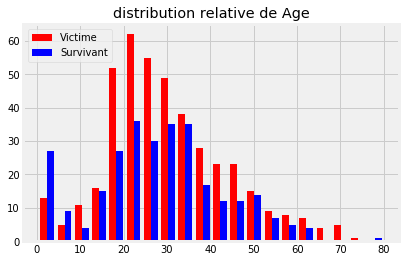

In [10]:
plot_hist('Age')

In [11]:
x['is_child'] = x["Age"] < 8
cols = [c for c in x.columns if 'Age' not in c]
X1 = x[cols]
compute_score(lr, X1, y)

Accurancy: 0.81 (+/- 0.04)


array([ 0.82122905,  0.81005587,  0.79213483,  0.78089888,  0.83050847])

In [12]:
lr.fit(X1, y)
coef = pd.DataFrame([list(x.columns), list(lr.coef_[0])])
coef

,0,1,2,3,4,5,6,7,8,9
0,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,is_child
1,-0.396665,-0.220217,0.00491543,0.786264,0.0780039,-0.837009,1.4092,-1.38194,2.21329,None


In [ ]:
#Le coeff élevé de is_child montre bien qu'on a plus de chance d'être survivant quand on est enfant. En rajoutant la variable
#is_child, nous avons crée la non linéarité qu'on modèle de régression simple ne peut pas capturer.
#Nous avons fait les premiers pas vers le feature engineering, qui est essentiel si vous voulez obtenir de belles performances avec les algorithmes de ML.